In [1]:
import pImpactR as impact
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy as copy
rectangular_ = 1
elliptic_ = 2

In [2]:
npt = 1
nturn = 1024
dipoleFF = 3

# read Aperture

In [3]:
aperture = np.loadtxt('pipeinfo.in')

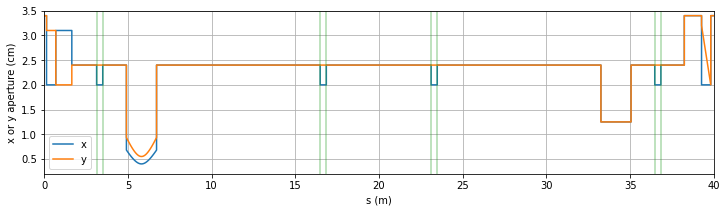

In [4]:
plt.figure(figsize=(12,3))
plt.plot(aperture[:,0],aperture[:,1]*100)
plt.plot(aperture[:,0],aperture[:,2]*100)
plt.plot(aperture[:,0],(aperture[:,3]-1)*10,alpha=0.4)
plt.grid()
plt.ylim((0.2,3.5))
plt.xlim((0.0, 40))
plt.legend(('x','y'))
plt.xlabel('s (m)')
plt.ylabel('x or y aperture (cm)');

In [5]:
aperture[-1,0]

39.968229720000004

# Prepare impact run

In [6]:
beam,lattice = impact.readInputFile('test.Chad.in')
beam.frequency = impact.data.clight/360

ke = beam.kinetic_energy
mass = beam.mass
freq = beam.frequency

g = ke/mass+1.0
bg = np.sqrt(g**2-1.0)

reading ImpactZ input file (test.Chad.in)
  : mpi task info .............................done
  : simulation control parameters .............done
  : space charge field solver, mesh info ......done
  : dist-type,restart,subcycle,#of state ......done
  : Multiple Charge State info ................done
  : particle distribution info ................done
  : beam reference orbit info .................done
  : converting impact dist to twiss param......done
  : lattice info ..............................done


In [7]:
beam.distribution.distribution_type = 'ReadFile'
beam.n_particles = 1
beam.nCore_y = 1
beam.nCore_z = 1

In [8]:
cleanLat = []
pre = lattice[0]
L = 0 
for item in lattice:
    if item.type == 'RFkick':
        item.vmax = 0.0
    if item.type == 'nonlinear_insert':
        item.type = 'drift'
        print('NL:',L,L+item.length)
    if item.type not in ['-8', 'write_raw_ptcl', 'halt']:
        cleanLat.append(item)
    if 'length' in item:
        L = L+item.length
print(L-aperture[-1,0])

NL: 4.9115191429 6.711519142899999
-4.199918635094946e-09


In [9]:
quadIndex = []
quadStr = []
for i,item in enumerate(cleanLat):
    if 'length' in item:
        item.n_sckick = int(np.ceil(item.length*50))
        item.n_map = 1
    if item.type=='quad':
        quadIndex.append(i)
        quadStr.append(item.Kx)

In [10]:
for i,j in enumerate(quadIndex):
    heqf1 = impact.getElem('quad_hardedge')
    heqf1.n_sckick = 100
    heqf1.flagEntrance=True
    heqf1.Kx = quadStr[i]
    cleanLat.insert(j+2*i,heqf1)
    heqf2 = copy(heqf1)
    heqf2.flagEntrance=False
    cleanLat.insert(j+2*i+2,heqf2)

In [11]:
# cleanLat.insert(0,impact.getElem('pipeinfo'))
cleanLat[0].turns = nturn

In [12]:
M=impact.getTransferMap(beam,cleanLat)

In [13]:
M

,0,1,2,3,4,5
0,-0.309024,0.533585,0.000000,0.000000,0.000000,-5.025890e-08
1,-1.695144,-0.309024,0.000000,0.000000,0.000000,-6.508437e-08
2,0.000000,0.000000,-0.309017,1.317348,0.000000,0.000000e+00
3,0.000000,0.000000,-0.686613,-0.309017,0.000000,0.000000e+00
4,-4.460831,-3.444442,-0.000054,0.000347,0.999995,-1.011461e-04
5,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,1.000000e+00


In [14]:
M.values[4,:4]=M.values[4,:4]/freq/360*3.0e8
M.values[4,-1]=M.values[4,-1]/freq/360*3.0e8

In [15]:
M

,0,1,2,3,4,5
0,-0.309024,0.533585,0.000000,0.000000,0.000000,-5.025890e-08
1,-1.695144,-0.309024,0.000000,0.000000,0.000000,-6.508437e-08
2,0.000000,0.000000,-0.309017,1.317348,0.000000,0.000000e+00
3,0.000000,0.000000,-0.686613,-0.309017,0.000000,0.000000e+00
4,-4.463919,-3.446826,-0.000054,0.000347,0.999995,-1.012162e-04
5,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,1.000000e+00


In [16]:
M.values[:5,-1]=-M.values[:5,-1]*mass*bg
M

,0,1,2,3,4,5
0,-0.309024,0.533585,0.000000,0.000000,0.000000,3.444700
1,-1.695144,-0.309024,0.000000,0.000000,0.000000,4.460825
2,0.000000,0.000000,-0.309017,1.317348,0.000000,-0.000000
3,0.000000,0.000000,-0.686613,-0.309017,0.000000,-0.000000
4,-4.463919,-3.446826,-0.000054,0.000347,0.999995,6937.266531
5,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,1.000000


In [17]:
freq

832756.8277777778

# Prepare pData

In [18]:
pData = np.zeros([1,9])
q_m = beam.multi_charge.q_m[0]
pData[0,0] = 0.01
pData[0,2] = 0.01
pData[:,-1] = 1
pData[:,-3] = q_m
beam.n_particles = 1

impact.writeParticleData(pData, ke, mass, freq)

In [19]:
TBT = impact.getElem('TBT')
TBT.pID_end = npt
TBT.file_id = 1111
cleanLat.insert(2,TBT)

# writeP = impact.getElem('write_raw_ptcl')
# writeP.file_id = 1110
# writeP.turn = 1
# writeP.format_id = 2
# cleanLat.insert(2,writeP)

# nStep Hard Edges

In [20]:
def run(nSteps):
    TBT.file_id = 1000+nSteps
    for item in cleanLat:
        if item.type == 'quad_hardedge':
            item.n_map = nSteps
    impact.writeInputFile(beam,cleanLat)
    impact.run(beam,order=dipoleFF)
    dummy,data = impact.readTBT(1000+nSteps,ke,mass,freq)
    data = data[:,:4,0]
    return data

In [21]:
TBTdata={}

In [22]:
TBTdata[100]=run(100)
TBTdata[1]=run(1)
TBTdata[0]=run(0)

# test with MLI

In [23]:
pData = impact.readParticleData(1110,ke,mass,freq,2)

In [24]:
MLI = impact.MLI

In [25]:
elems,line = impact.impact2mli(beam,lattice)

Impact elem type loop is not recognized from MLI. skipping...
Impact elem type write_raw_ptcl is not recognized from MLI. skipping...
Impact elem type write_raw_ptcl is not recognized from MLI. skipping...
Impact elem type -8 is not recognized from MLI. skipping...
Impact elem type RFkick is not recognized from MLI. skipping...
Impact elem type write_raw_ptcl is not recognized from MLI. skipping...
Impact elem type -8 is not recognized from MLI. skipping...


In [26]:
elems[2].lfrngquad = 1
elems[2].tfrngquad = 1

In [27]:
readP = MLI.getElem.raytrace()
track = MLI.getElem.autotrack()
dump = MLI.getElem.particledump()
elems = elems + [readP,track,dump]
line.list.append(dump.name)
line.name

'impactLattice'

In [28]:
labor = MLI.buildLabor([readP,track,'1024*impactLattice'])

In [29]:
MLI.writeInputfile(elems,[line],labor)

In [30]:
np.savetxt('rays.in',pData[:,:6])

In [31]:
MLI.run()

In [32]:
TBT_MLI = np.loadtxt('rays.out')
TBT_MLI.shape

(1024, 8)

In [33]:
elems[2].lfrngquad=0
elems[2].tfrngquad=0
MLI.writeInputfile(elems,[line],labor)
MLI.run()
TBT_MLI_noQF = np.loadtxt('rays.out')
TBT_MLI_noQF.shape

(1024, 8)

# plot

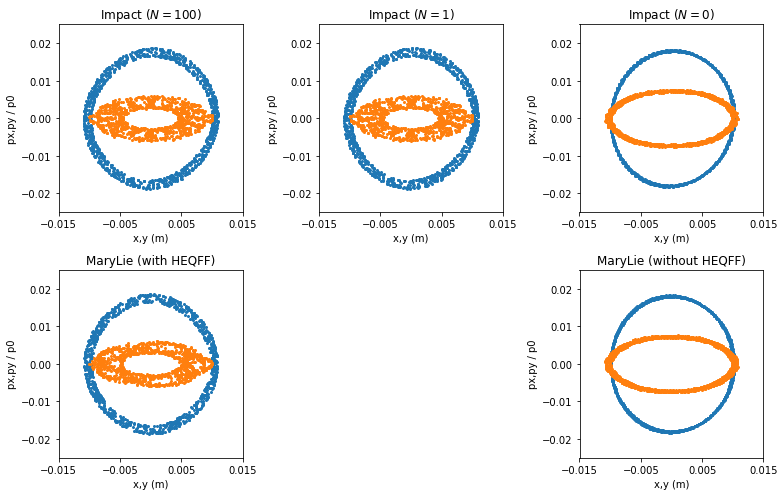

In [40]:
plt.figure(figsize=(11,7))
plt.subplot(2,3,1)
plt.scatter(TBTdata[100][:,0],TBTdata[100][:,1],s=4)
plt.scatter(TBTdata[100][:,2],TBTdata[100][:,3],s=4)
plt.xlabel('x,y (m)')
plt.ylabel('px,py / p0')
plt.title('Impact ($N=100$)')
plt.xticks([-0.015,-0.005,0.005,0.015])
plt.xlim(-0.015,0.015)
plt.ylim(-0.025,0.025)
plt.subplot(2,3,2)
plt.scatter(TBTdata[1][:,0],TBTdata[1][:,1],s=4)
plt.scatter(TBTdata[1][:,2],TBTdata[1][:,3],s=4)
plt.xlabel('x,y (m)')
plt.ylabel('px,py / p0')
plt.title('Impact ($N=1$)')
plt.xticks([-0.015,-0.005,0.005,0.015])
plt.xlim(-0.015,0.015)
plt.ylim(-0.025,0.025)
plt.subplot(2,3,3)
plt.scatter(TBTdata[0][:,0],TBTdata[0][:,1],s=4)
plt.scatter(TBTdata[0][:,2],TBTdata[0][:,3],s=4)
plt.xlabel('x,y (m)')
plt.ylabel('px,py / p0')
plt.title('Impact ($N=0$)')
plt.xticks([-0.015,-0.005,0.005,0.015])
plt.xlim(-0.015,0.015)
plt.ylim(-0.025,0.025)
plt.subplot(2,3,4)
plt.scatter(TBT_MLI[:,1],TBT_MLI[:,2],s=4)
plt.scatter(TBT_MLI[:,3],TBT_MLI[:,4],s=4)
plt.xlabel('x,y (m)')
plt.ylabel('px,py / p0')
plt.xticks([-0.015,-0.005,0.005,0.015])
plt.xlim(-0.015,0.015)
plt.ylim(-0.025,0.025)
plt.title('MaryLie (with HEQFF)')
plt.subplot(2,3,6)
plt.scatter(TBT_MLI_noQF[:,1],TBT_MLI_noQF[:,2],s=4)
plt.scatter(TBT_MLI_noQF[:,3],TBT_MLI_noQF[:,4],s=4)
plt.xlabel('x,y (m)')
plt.ylabel('px,py / p0')
plt.xticks([-0.015,-0.005,0.005,0.015])
plt.xlim(-0.015,0.015)
plt.ylim(-0.025,0.025)
plt.title('MaryLie (without HEQFF)')
plt.tight_layout()
plt.savefig('testHEQFF.HEDFF3.png',dpi=180)

# MLI map

In [35]:
mapout = MLI.getElem.ptm()

In [36]:
elems.append(mapout)
labor = MLI.buildLabor([line,mapout])

In [37]:
MLI.writeInputfile(elems,[line],labor)
MLI.run()

In [38]:
M,G = MLI.readTransferMap()

In [39]:
M

,1,2,3,4,5,6
1,-0.309024,0.533585,0.000000,0.000000,0.0,3.444705
2,-1.695144,-0.309024,0.000000,0.000000,0.0,4.460781
3,0.000000,0.000000,-0.309017,1.317348,0.0,0.000000
4,0.000000,0.000000,-0.686613,-0.309017,0.0,0.000000
5,-4.460781,-3.444705,0.000000,0.000000,1.0,6932.469613
6,0.000000,0.000000,0.000000,0.000000,0.0,1.000000
